# Portfolio Construction

In [1]:
import os
import joblib
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import cvxpy as cp
from sklearn.covariance import LedoitWolf
from pykrx import stock

from Alpha_Research import Alpha_Research

In [2]:
data_folder = "data"
model_folder = "model"

stack_name = os.path.join(data_folder, "data_stack.h5")
df_stack = pd.read_hdf(stack_name)

In [3]:
def qs_medians(train_df):
    qs_medians = {}
    
    sectors = train_df['fgsc'].unique()
    dates = train_df.index.get_level_values(0).unique()
    
    for sector in sectors:
        qs_list = []
        
        sector_mask_train = (train_df['fgsc']==sector)
        
        df_train_sector = train_df[sector_mask_train]
        
        for dt in dates:
            date_mask = (df_train_sector.index.get_level_values(0)==dt)
            df_temp = df_train_sector[date_mask]
            
            qs = [df_temp['target'].quantile((2*i+1)/10) for i in range(5)]
            qs_list.append(qs)
        # median value to represent time-series wise
        qs_median = pd.DataFrame(qs_list).median().to_list()
        qs_medians[sector] = qs_median
        
    return qs_medians

In [4]:
def q_restoring(q_label, test_df, qs_medians):
    test_targets = []
    q_label = pd.Series(q_label, index=test_df.index)
    
    sectors = test_df['fgsc'].unique()
    
    for sector in sectors:
        sector_mask_test = (test_df['fgsc']==sector)
        q_label_sector = q_label[sector_mask_test]
        qs_median = qs_medians[sector]
        test_targets.append(q_label_sector.apply(lambda x: qs_median[int(x)-1]))
    
    restored_target_test = pd.concat(test_targets).loc[test_df.index]
    return restored_target_test

In [5]:
ar = Alpha_Research()

In [6]:
def ledoit_wolf_cov(price_data, universe, scaling=252/12):
    df_ret = (1+price_data.pct_change()).apply(np.log).iloc[1:]
    df_ret = df_ret.T.fillna(df_ret.mean(axis=1)).T
    cov = LedoitWolf().fit(df_ret)
    df_cov = pd.DataFrame(cov.covariance_*np.sqrt(scaling),
                      index=universe, columns=universe)
    return df_cov

In [7]:
df_isos_year = {}
models_dict = {}

for year in range(2018, 2023):
    index_year_1 = (df_stack.index.get_level_values(0).year<=year)
    index_year_2 = (df_stack.index.get_level_values(0).year<=year+1)
    
    df_stack_is = df_stack[index_year_1]
    df_stack_os = df_stack[~index_year_1&index_year_2]
    df_isos_year[year] = [df_stack_is.copy(), df_stack_os.copy()]
    
    model_name = os.path.join(model_folder, f"cat_{year}.json")
    model = CatBoostClassifier()
    model.load_model(model_name)
    models_dict[year] = model

# Out-Of-Sample Only

In [8]:
# portfolio optimization
portfolio_opt_results = dict()

time_index = df_stack.index.get_level_values(0).unique()
time_index = time_index[time_index.year>=2019]

year_memory = None
for dt in tqdm(time_index):
    # use updated training file
    df_is = df_isos_year[dt.year-1][0].copy()
    df_os = df_isos_year[dt.year-1][1].copy()
    dataset = df_os.copy()

    df_os_dts = df_os.reset_index()['Date']
    df_os_dt = df_os_dts[~df_os_dts.duplicated()].to_list()

    model = CatBoostClassifier()
    model = models_dict[dt.year-1]
    
    if dt.year != year_memory:
        qs_median = qs_medians(df_is)
        year_memory = dt.year
    else:
        pass
    
    # expexted return
    temp_sectors = ar.sector_dict[dt]
    X = dataset[dataset.index.get_level_values(0)==dt].iloc[:,:-1]
    universe = X.index.get_level_values(1)
    temp_index_weight = pd.Series(ar.data_weight[dt])[universe]
    y_q = pd.Series(model.predict(X).reshape(len(X)), index=X.index)
    y = q_restoring(y_q, X, qs_median).to_numpy()
    # boolean mask for sector
    w_s = []
    for sc in temp_sectors.keys():
        w_s.append(temp_index_weight.index.isin(temp_sectors[sc]))
        
    # covariance estimation with Ledoit-Wolf Shirnkage
    idx = ar.d['ADJC'].index.to_list().index(dt)
    df_p = ar.d['ADJC'][universe].iloc[idx-252*3:idx+1]
    df_cov = ledoit_wolf_cov(df_p, universe)

    # long-short mean variance optimization
    # define variables
    w = cp.Variable(len(universe))
    var = cp.quad_form(w, df_cov.to_numpy())
    e_r = y @ w

    ub = cp.Parameter(nonneg=True, name='ub')
    lb = cp.Parameter(nonneg=True, name='lb')
    net = cp.Parameter(nonneg=True, name='net')
    gross = cp.Parameter(nonneg=True, name='gross')
    target = cp.Parameter(nonneg=True, name='target')
    sc_net = cp.Parameter(nonneg=True, name='sc_net')
    sc_gross = cp.Parameter(nonneg=True, name='sc_gross')
    
    idx_w = temp_index_weight.to_numpy()

    # define objective, constraints and problem
    objective = cp.Maximize(e_r)
    constraints = [var <= target,
                   cp.sum(w) == net,
                   cp.sum(cp.abs(w)) <= gross,
                   w >= -lb,
                   w <= ub,
                   w >= -idx_w]
    
    for i in range(len(w_s)):
        constraints.append(cp.sum(w @ w_s[i]) == sc_net)
        constraints.append(cp.sum(cp.abs(w @ w_s[i])) <= gross * (w_s[i] @ idx_w))

    problem = cp.Problem(objective, constraints)

    # assign value to parameters
    target.value = 0.20
    net.value = 0.0
    gross.value = 2.0
    ub.value = 0.15 * gross.value
    lb.value = 0.15 * gross.value
    sc_net.value = 0.00
    
    # solve
    problem.solve()
    portfolio_opt_results[dt] = {'E_r':e_r.value,
                                 'var':var.value,
                                 'w':w.value,
                                 'universe':universe,
                                 'index':idx_w}

100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:59<00:00,  1.11s/it]


In [9]:
bt_dict = dict()
for dt in tqdm(time_index):
    temp_opt = portfolio_opt_results[dt]
    temp_universe = temp_opt['universe']
    temp_target = ar.df_target.loc[dt][temp_universe]
    ls_w = temp_opt['w']
    lo_w = temp_opt['w'] + temp_opt['index']
    bt_dict[dt] = {'Long-Short':(ls_w * temp_target).sum(),
                   'Long-Only':(lo_w * temp_target).sum()}

100%|█████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 984.46it/s]


In [10]:
bt_ret = pd.DataFrame(bt_dict).T
benchmark = ar.data_index['KS200']
# shift 1 month
start = bt_ret.index[1]
end = benchmark[benchmark.index>bt_ret.index[-1]].index[0]
new_index = benchmark[(benchmark.index>=start)&(benchmark.index<=end)].index
bt_ret.set_index(new_index, inplace=True)
bt_ret['KS200'] = benchmark / 100
bt_cum = (1+bt_ret).cumprod()

In [11]:
portfolio_path = "portfolio"
portfolios = [bt_ret, bt_cum]
joblib.dump(portfolios, os.path.join(portfolio_path, 'portfolio.sav'), compress=1)

['portfolio\\portfolio.sav']

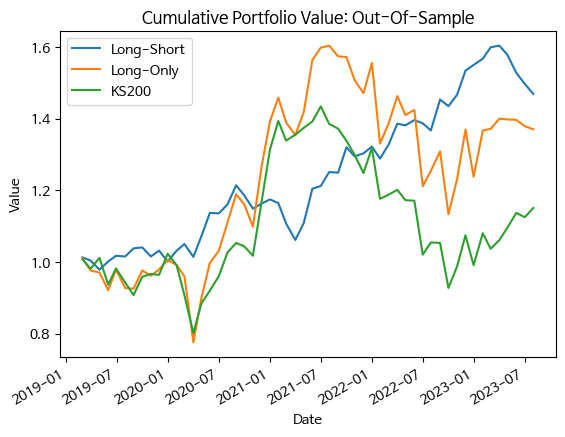

In [12]:
plot_name = os.path.join(portfolio_path, 'Portfolio_Value_OS.png')
fig1, ax1 = plt.subplots()
bt_cum.plot(ax=ax1)
ax1.set_title("Cumulative Portfolio Value: Out-Of-Sample")
ax1.set_xlabel("Date")
ax1.set_ylabel("Value")
ax1.legend()
fig1.figure.savefig(plot_name, bbox_inches='tight', dpi=300)

In [13]:
pd.set_option('display.float_format', '{:.4%}'.format)

In [14]:
sector_name = {'FGSC.55':'유틸리티',
               'FGSC.40':'금융',
               'FGSC.30':'필수소비재',
               'FGSC.35':'의료',
               'FGSC.20':'산업재',
               'FGSC.50':'통신서비스',
               'FGSC.15':'소재',
               'FGSC.45':'IT',
               'FGSC.25':'경기소비재',
               'FGSC.10':'에너지'}

In [20]:
for i in tqdm(range(24, 36)):
    dt = time_index[i]
    temp_opt = portfolio_opt_results[dt]
    universe = temp_opt['universe']
    name = [stock.get_market_ticker_name(i[1:]) for i in universe]
    active_weight = temp_opt['w']
    passive_weight = temp_opt['index']

    df_w = pd.DataFrame({'Active_Weight':active_weight,
                         'Passive_Weight':passive_weight}, index=name)
    df_w['Total_Weight'] = df_w['Active_Weight'] + df_w['Passive_Weight']
    df_w['Sector'] = [sector_name[ar.fgsc[i]] for i in universe]
    df_w = df_w.sort_values(by='Total_Weight', ascending=False)

    weight_name = f"Portfolio_Weight_{dt.strftime('%Y%m%d')}.xlsx"
    weight_dir = os.path.join(portfolio_path, weight_name)
    df_w.to_excel(weight_dir)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.55it/s]
